## Libraries

In [1]:
# This is our custom implementation of the KNN algorithm, the algorithm is in the path knn/knn_implementation.py
from knn_implementation import KNN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
    )
import time

import numpy as np
import pandas as pd

## Usage example

In [2]:
# Basic training and test data
X_train = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
y_train = np.array([0, 1, 0, 1, 0])

X_test = np.array([[4, 6], [3, 4], [4, 5]])

# Initialize the KNN algorithm
# Parameters:
# k: Number of neighbors to consider (default=3)
# distance: Distance metric to use (default='euclidean'), options: 'euclidean', 'manhattan', 'cosine' 
# weighted: Assign weights to the neighbors based on their distance (default=False)
knn = KNN(k=6, distance='cosine', weighted=True)

# Function to "train" the algorithm, in this case it just stores the training data
knn.fit(X_train, y_train)

# Function to predict the class of the test data
prediction = knn.predict(X_test)

prediction

[0.990613562781246, 0.02564608169651176, 0.936341882823386]

## Dataset 1 - Bike Sharing

### Data preprocessing


In [3]:
# Load the bike sharing dataset
from sklearn.preprocessing import OneHotEncoder

bike_sharing = pd.read_csv('../datasets/original/bike_sharing.csv')

bike_sharing = bike_sharing.drop(['casual', 'registered'], axis=1)

encoderOHE = OneHotEncoder()

# one-hot encoding for the categorical variables season, weathersit
season_encoded = encoderOHE.fit_transform(bike_sharing[['season']]).toarray()
weathersit_encoded = encoderOHE.fit_transform(bike_sharing[['weathersit']]).toarray()

# Add the encoded columns to the dataset
bike_sharing['spring'] = season_encoded[:, 0]
bike_sharing['summer'] = season_encoded[:, 1]
bike_sharing['fall'] = season_encoded[:, 2]
bike_sharing['winter'] = season_encoded[:, 3]

bike_sharing['weather_1'] = weathersit_encoded[:, 0]
bike_sharing['weather_2'] = weathersit_encoded[:, 1]
bike_sharing['weather_3'] = weathersit_encoded[:, 2]
bike_sharing['weather_4'] = weathersit_encoded[:, 3]

# Drop the original columns
bike_sharing = bike_sharing.drop(['season', 'weathersit'], axis=1)

# Drop columns that are not needed
bike_sharing = bike_sharing.drop(['instant', 'dteday'], axis=1)

### Splitting the data and normalizing it

In [4]:
# Split the dataset into features and target variable
X = bike_sharing.drop('cnt', axis=1)
y = bike_sharing['cnt']

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Note: In a previous test I normalized the columns 'casual', 'registered' and the results were way worse. With mae around 30 and mse around 1700
# With the current configuration we are getting good results, mae around ~1 and mse around ~5-30
variables_to_normalize = ['mnth', 'hr', 'weekday']

X_train[variables_to_normalize] = scaler.fit_transform(X_train[variables_to_normalize]) 
X_test[variables_to_normalize] = scaler.transform(X_test[variables_to_normalize])

X_train
 

,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,spring,summer,fall,winter,weather_1,weather_2,weather_3,weather_4
1945,0,0.181818,0.869565,0,1.000000,0,0.28,0.2727,0.45,0.2537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
13426,1,0.545455,0.652174,0,0.500000,1,0.92,0.8485,0.35,0.3582,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12898,1,0.454545,0.652174,0,0.333333,1,0.72,0.6515,0.28,0.4627,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2570,0,0.272727,0.000000,0,0.833333,1,0.36,0.3485,0.62,0.1940,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
10764,1,0.181818,0.652174,0,0.666667,1,0.52,0.5000,0.39,0.3582,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1,0.272727,0.391304,0,0.833333,1,0.46,0.4545,0.88,0.0896,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11964,1,0.363636,0.739130,0,0.833333,1,0.66,0.6212,0.34,0.1343,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5390,0,0.636364,0.521739,0,0.500000,1,0.80,0.7273,0.43,0.2836,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
860,0,0.090909,0.304348,0,0.333333,1,0.24,0.1970,0.65,0.4179,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Testing multiple configurations

In [5]:
def predict_knn_all_configurations(X_train, y_train, X_test, y_test, min_k=5, max_k=5):
    results = []
    for k in range(min_k, max_k+1):
        for distance in ['euclidean', 'manhattan', 'cosine']:
            for weighted in [True, False]:
                knn = KNN(k=k, distance=distance, weighted=weighted)
                knn.fit(X_train, y_train)
                prediction = knn.predict(X_test)
                mae = mean_absolute_error(y_test, prediction)
                mse = mean_squared_error(y_test, prediction)
                r2 = r2_score(y_test, prediction)
                results.append({
                    'k': k,
                    'distance': distance,
                    'weighted': weighted,
                    'mae': mae,
                    'mse': mse,
                    'r2': r2
                })
    return results

In [6]:
results = predict_knn_all_configurations(X_train, y_train, X_test, y_test, 6, 8)

results

[{'k': 6,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 60.479179504313755,
  'mse': 8656.624331850098,
  'r2': 0.7308122253536535},
 {'k': 6,
  'distance': 'euclidean',
  'weighted': False,
  'mae': 64.45868814729575,
  'mse': 9490.486651323361,
  'r2': 0.7048823093106784},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': True,
  'mae': 62.366232837628125,
  'mse': 9233.47631514394,
  'r2': 0.7128743438272624},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': False,
  'mae': 67.14652857690832,
  'mse': 10328.750888633167,
  'r2': 0.6788155105266751},
 {'k': 6,
  'distance': 'cosine',
  'weighted': True,
  'mae': 59.02980206797745,
  'mse': 8579.296468631099,
  'r2': 0.7332168249550817},
 {'k': 6,
  'distance': 'cosine',
  'weighted': False,
  'mae': 64.56547756041427,
  'mse': 9566.756476153945,
  'r2': 0.7025106106401847},
 {'k': 7,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 61.19589033191054,
  'mse': 8710.97553097296,
  'r2': 0.729122111773535},
 {'k': 7,

In [7]:
knn = KNN(k=6, distance='euclidean', weighted=True)

knn.fit(X_train, y_train)

runtime_start = time.process_time()
prediction = knn.predict(X_test)
runtime_end = time.process_time()
mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)


runtime = runtime_end - runtime_start

mae, mse, r2, runtime

(60.479179504313755, 8656.624331850098, 0.7308122253536535, 25.625)

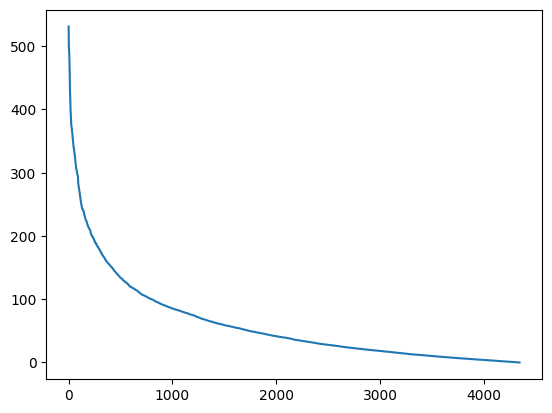

In [8]:
# Plot difference between real and predicted values
from matplotlib import pyplot as plt

# List of values y_test - prediction and sort it descending
sorted_values = sorted(abs(y_test.values - prediction), reverse=True)


plt.plot(sorted_values)
plt.show()


## Dataset 2 - Combined Cycle Power Plant 

In [9]:
# Load the combined cycle power plant dataset
ccpp = pd.read_csv('../datasets/original/ccpp.csv')

# Split the dataset into features and target variable
ccpp_X = ccpp.drop('PE', axis=1)
ccpp_y = ccpp['PE']

# Split the dataset into training and testing data
ccpp_X_train, ccpp_X_test, ccpp_y_train, ccpp_y_test = train_test_split(ccpp_X, ccpp_y, test_size=0.25, random_state=42)

# Normalize the data
scaler = MinMaxScaler()

variables_to_normalize = ['AT', 'V', 'AP', 'RH']

# Fit transform varirables AT, V, AP, RH
ccpp_X_train[variables_to_normalize] = scaler.fit_transform(ccpp_X_train[variables_to_normalize]) 
ccpp_X_test[variables_to_normalize] = scaler.transform(ccpp_X_test[variables_to_normalize])

ccpp_X_train

,AT,V,AP,RH
2058,0.464589,0.289493,0.005444,0.492425
8042,0.839377,0.712879,0.523385,0.316262
7612,0.314448,0.297337,0.506805,0.616168
1166,0.386969,0.385261,0.366246,0.878268
3597,0.838244,0.751186,0.263796,0.431291
...,...,...,...,...
5734,0.692351,0.650493,0.459787,0.612146
5191,0.775071,0.719263,0.582529,0.475801
5390,0.458640,0.334549,0.557040,0.478885
860,0.705949,0.793141,0.441970,0.553291


In [12]:
ccpp_results = predict_knn_all_configurations(ccpp_X_train, ccpp_y_train, ccpp_X_test, ccpp_y_test, 6, 8)

ccpp_results

[{'k': 6,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 2.56274479040686,
  'mse': 12.794298920941605,
  'r2': 0.9555906664699434},
 {'k': 6,
  'distance': 'euclidean',
  'weighted': False,
  'mae': 2.715487040133779,
  'mse': 13.661394512959868,
  'r2': 0.9525809558491174},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': True,
  'mae': 2.484261130069101,
  'mse': 11.977964870079374,
  'r2': 0.9584241825039752},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': False,
  'mae': 2.6556319676700118,
  'mse': 13.037069798634338,
  'r2': 0.9547480026440112},
 {'k': 6,
  'distance': 'cosine',
  'weighted': True,
  'mae': 3.5032846105594126,
  'mse': 22.73488833152806,
  'r2': 0.9210866304654765},
 {'k': 6,
  'distance': 'cosine',
  'weighted': False,
  'mae': 3.6696467391304357,
  'mse': 23.33851691401896,
  'r2': 0.91899142046501},
 {'k': 7,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 2.583991025142546,
  'mse': 12.82062006478039,
  'r2': 0.9554993051172932},
 {'k'

## Dataset 3 - Online News Popularity

In [13]:
# Load the bike sharing dataset
online_news = pd.read_csv('../datasets/original/OnlineNewsPopularity.csv')

# Drop url since it functions as an ID
online_news = online_news.drop(['url'], axis=1)

# Split the dataset into features and target variable
on_X = online_news.drop('shares', axis=1)
on_y = online_news['shares']

# Split the dataset into training and testing data
on_X_train, on_X_test, on_y_train, on_y_test = train_test_split(on_X, on_y, test_size=0.25, random_state=42)

# Normalize the data
scaler = MinMaxScaler()


# Fit transform all variables
on_X_train_scaled = scaler.fit_transform(on_X_train) 
on_X_train = pd.DataFrame(on_X_train_scaled, columns=on_X_train.columns)
on_X_test_scaled = scaler.transform(on_X_test)
on_X_test =  pd.DataFrame(on_X_test_scaled, columns=on_X_test.columns)


least_important_features = [
'global_rate_negative_words',
'rate_positive_words',
'rate_negative_words',
'is_weekend',
'min_positive_polarity',
'max_positive_polarity',
'global_sentiment_polarity',
'avg_negative_polarity',
'min_negative_polarity',
'abs_title_subjectivity',
'LDA_00',
'timedelta',
'weekday_is_sunday',
'kw_min_min',
'n_non_stop_words',
'average_token_length',
'num_keywords',
'data_channel_is_lifestyle',
'data_channel_is_entertainment',
'data_channel_is_bus',
'data_channel_is_socmed',
'data_channel_is_tech',
'kw_max_min',
'weekday_is_saturday',
'kw_min_max',
'kw_max_max',
'n_tokens_title',
'weekday_is_monday',
'weekday_is_tuesday',
'weekday_is_wednesday',
'weekday_is_sunday',
'weekday_is_thursday',
'weekday_is_friday',
'abs_title_sentiment_polarity'
]

on_X_train = on_X_train.drop(least_important_features, axis=1)
on_X_test = on_X_test.drop(least_important_features, axis=1)

In [14]:
on_results = predict_knn_all_configurations(on_X_train, on_y_train, on_X_test, on_y_test, 6, 8)

on_results

[{'k': 6,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 3167.338215906787,
  'mse': 125991090.74659437,
  'r2': -0.08080699932008906},
 {'k': 6,
  'distance': 'euclidean',
  'weighted': False,
  'mae': 3166.312514714291,
  'mse': 125856818.66668348,
  'r2': -0.0796551543529489},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': True,
  'mae': 3123.856852644741,
  'mse': 122750693.82594252,
  'r2': -0.05300944909917815},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': False,
  'mae': 3128.011788248747,
  'mse': 123485010.82268576,
  'r2': -0.05930874331987912},
 {'k': 6,
  'distance': 'cosine',
  'weighted': True,
  'mae': 3216.1975750738043,
  'mse': 127239227.13999622,
  'r2': -0.09151406235209403},
 {'k': 6,
  'distance': 'cosine',
  'weighted': False,
  'mae': 3202.0335317660515,
  'mse': 126274562.35596812,
  'r2': -0.08323874348314186},
 {'k': 7,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 3154.253801910758,
  'mse': 124495743.81163941,
  'r2': -0.0679792